In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
multi_class_images = joblib.load(f"{DATAROOT}/multi_label_images.dict")
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")

In [6]:
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in multi_class_images}

In [7]:
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in multi_class_images}

In [8]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(multi_class_images)

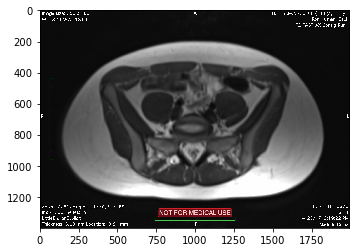

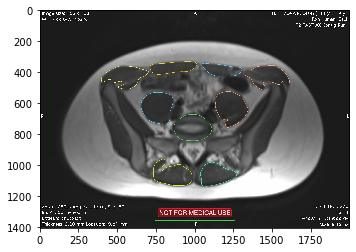

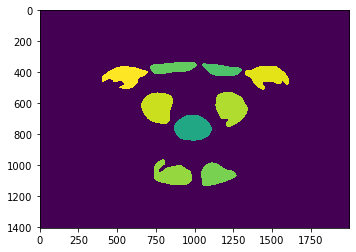

In [9]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

In [10]:
TRAIN_SIZE = 400

In [11]:
from sklearn.model_selection import train_test_split
imgTrLabels, imgTsLabels, maskedTrLabels, maskedTsLabels = \
    train_test_split(list(original_images.keys()), list(multi_class_images.keys()), random_state=17, test_size=.8)
imgTr = {k: original_images[k] for k in imgTrLabels}
imgTs = {k: original_images[k] for k in imgTsLabels}
maskedTr = {k: multi_class_images[k] for k in maskedTrLabels}
maskedTs = {k: multi_class_images[k] for k in maskedTsLabels}
assert len(imgTr) == len(maskedTr)
assert len(imgTs) == len(maskedTs)

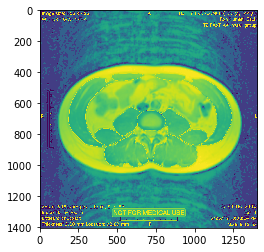

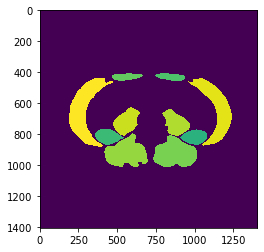

In [14]:
label = np.random.choice(list(maskedTr.keys()))
plt.imshow(cv2.equalizeHist(imgTr[label].mean(axis=2).astype('uint8')))
plt.show()
plt.imshow(maskedTr[label])

In [28]:
def clean_image(img, shape):
    #img = img.astype('uint8')
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    #cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in img.shape)
    blurred_img = cv2.GaussianBlur(img, gaussian_kernel_size, 1)
    #zoom_rate = tuple(x/y for x,y in zip(shape, blurred_img.shape)) if isinstance(shape, tuple) \
    #            else shape if shape < 1 else shape/img.shape[0]
    #out = zoom(img, zoom_rate)
    out = cv2.resize(blurred_img, shape)
    out = (out - out.mean())/out.std()
    return np.array([out]*3).transpose((1, 2, 0))

def clean_mask(img, shape):
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = ((zoom((img==c)*255, zoom_rate)>0)*1).astype('uint8')
        _, cnts, _ = cv2.findContours(segment.astype('uint8'),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(segment, cnts, -1, 2, 2)
        out.append(segment)
    return np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/4.WF4B-21:50.jpg


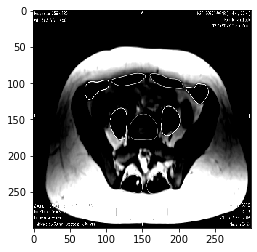

[0 1 2]


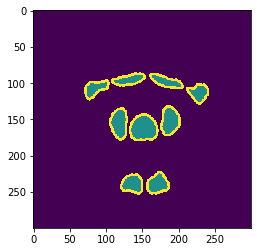

In [30]:
label = np.random.choice(list(maskedTr.keys()))
#label = "mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Female/Subject WF5B/1-WF5B-4:50RepBeh.jpg"
#label = 'mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Rep-Beh.jpg'
print(label)
plt.imshow(clean_image(imgTr[label], (300, 300)))
plt.show()
tmp = clean_mask(maskedTr[label], (300, 300))
plt.imshow(tmp)
print(np.unique(tmp))

In [31]:
imgTrB = bag.from_sequence(imgTr.values())
maskedTrB = bag.from_sequence(maskedTr.values())

In [32]:
cleaned_images_bag = imgTrB.map(clean_image, shape=(256, 256)).compute()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

In [33]:
cleaned_masks_bag = maskedTrB.map(clean_mask, shape=(256, 256)).compute()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


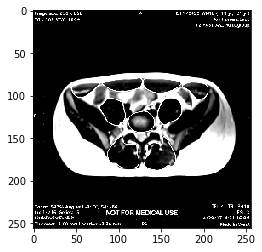

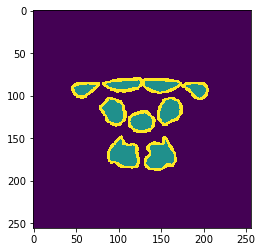

In [34]:
n = np.random.randint(len(cleaned_images_bag))
plt.imshow(cleaned_images_bag[n])
plt.show()
plt.imshow(cleaned_masks_bag[n])

In [35]:
X = np.array(cleaned_images_bag)
Y = np.array(cleaned_masks_bag).reshape(-1, 256, 256, 1)
#Y = np.concatenate([x[1] for x in XY])
#encoder = OneHotEncoder()
#Y = encoder.fit_transform(Y).toarray()

# Result: Failed

In [36]:
import tensorflow as tf

In [37]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [38]:
OUTPUT_CHANNELS = 3

In [39]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/bzr0014/anaconda3/envs/tensorGpu4/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [40]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [41]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 1, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [45]:
TRAIN_LENGTH = len(X)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

EPOCHS = 1000
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

Train on 155 samples
Epoch 1/1000
155/155 [==============================] - 31s 201ms/sample - loss: 0.9770 - acc: 0.8288
Epoch 2/1000
112/155 [====================>.........] - ETA: 8s - loss: 0.8790 - acc: 0.8572 

KeyboardInterrupt: 

In [ ]:
ypred = model.predict(X[0:1])

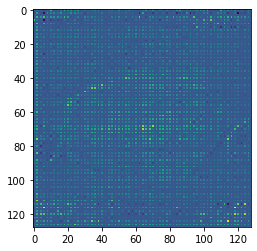

In [62]:
plt.imshow(ypred.reshape(128, 128, 3)[:, :, 2])

In [91]:
Y.shape

(155, 128, 128, 1)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [4]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

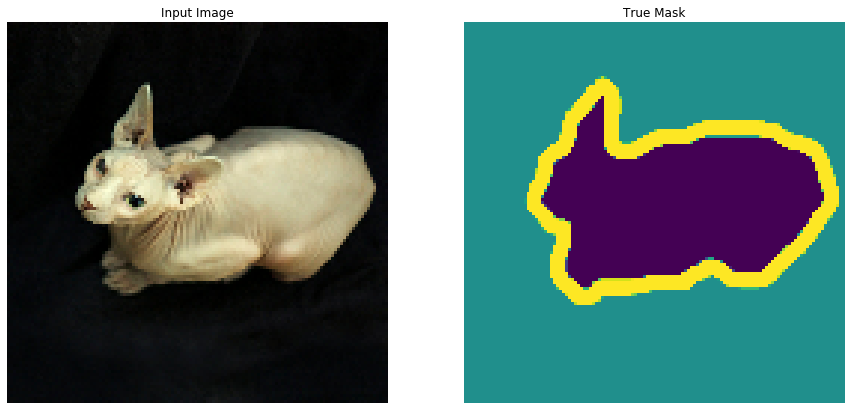

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [13]:
sample_image.shape

TensorShape([Dimension(128), Dimension(128), Dimension(3)])

In [96]:
2<<7

256